In [1]:
import pandas as pd
import sqlite3

conn = sqlite3.connect('sqlite_db_pythonsqlite.db')

c = conn.cursor()

       # Read the Facilities table from the database
rs_fac = c.execute("SELECT * FROM Facilities")
# names = list(map(lambda x: x[0], rs.description))
names = [x[0] for x in rs_fac.description]

df_facility = pd.DataFrame(rs_fac.fetchall())
df_facility.columns = names

       # Read the Bookings table from the database
rs_book = c.execute("SELECT * FROM Bookings")

df_booking = pd.DataFrame(rs_book.fetchall())
df_booking.columns = [x[0] for x in rs_book.description]

       # Read the Members table from the database
rs_member = c.execute("SELECT * FROM Members")

df_member = pd.DataFrame(rs_member.fetchall())
df_member.columns = [x[0] for x in rs_member.description]

In [2]:
df_facility.head()

,facid,name,membercost,guestcost,initialoutlay,monthlymaintenance
0,0,Tennis Court 1,5.0,25.0,10000,200
1,1,Tennis Court 2,5.0,25.0,8000,200
2,2,Badminton Court,0.0,15.5,4000,50
3,3,Table Tennis,0.0,5.0,320,10
4,4,Massage Room 1,9.9,80.0,4000,3000


In [3]:
df_booking.head()

,bookid,facid,memid,starttime,slots
0,0,3,1,2012-07-03 11:00:00,2
1,1,4,1,2012-07-03 08:00:00,2
2,2,6,0,2012-07-03 18:00:00,2
3,3,7,1,2012-07-03 19:00:00,2
4,4,8,1,2012-07-03 10:00:00,1


Q10: Produce a list of facilities with a total revenue less than 1000.
The output of facility name and total revenue, sorted by revenue. Remember
that there's a different cost for guests and members!

* First, booking and facilities tables must be joined on each facility id.

In [4]:
df_book_fac = df_booking.join(df_facility, on = 'facid',lsuffix='_book', rsuffix='_facility' , how = 'left')
df_book_fac.head()

,bookid,facid_book,memid,starttime,slots,facid_facility,name,membercost,guestcost,initialoutlay,monthlymaintenance
0,0,3,1,2012-07-03 11:00:00,2,3,Table Tennis,0.0,5.0,320,10
1,1,4,1,2012-07-03 08:00:00,2,4,Massage Room 1,9.9,80.0,4000,3000
2,2,6,0,2012-07-03 18:00:00,2,6,Squash Court,3.5,17.5,5000,80
3,3,7,1,2012-07-03 19:00:00,2,7,Snooker Table,0.0,5.0,450,15
4,4,8,1,2012-07-03 10:00:00,1,8,Pool Table,0.0,5.0,400,15


* A new column must be generated for the cost of each booking based on the type of guest. Depending on the type of visitor, number of slots must be multiplied by the rate.

In [5]:
import numpy as np

df_book_fac['cost'] = np.where(df_book_fac['memid'] ==0, df_book_fac['slots'] * df_book_fac['guestcost'], 
                               df_book_fac['slots'] * df_book_fac['membercost'])

In [6]:
df_book_fac

,bookid,facid_book,memid,starttime,slots,facid_facility,name,membercost,guestcost,initialoutlay,monthlymaintenance,cost
0,0,3,1,2012-07-03 11:00:00,2,3,Table Tennis,0.0,5.0,320,10,0.0
1,1,4,1,2012-07-03 08:00:00,2,4,Massage Room 1,9.9,80.0,4000,3000,19.8
2,2,6,0,2012-07-03 18:00:00,2,6,Squash Court,3.5,17.5,5000,80,35.0
3,3,7,1,2012-07-03 19:00:00,2,7,Snooker Table,0.0,5.0,450,15,0.0
4,4,8,1,2012-07-03 10:00:00,1,8,Pool Table,0.0,5.0,400,15,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4038,4038,8,29,2012-09-30 16:30:00,2,8,Pool Table,0.0,5.0,400,15,0.0
4039,4039,8,29,2012-09-30 18:00:00,1,8,Pool Table,0.0,5.0,400,15,0.0
4040,4040,8,21,2012-09-30 18:30:00,1,8,Pool Table,0.0,5.0,400,15,0.0
4041,4041,8,16,2012-09-30 19:00:00,1,8,Pool Table,0.0,5.0,400,15,0.0


* Now, it's time to add up the booking cost to get the revenue for each facility.

In [7]:
df_revenue = df_book_fac[['facid_facility','cost']].groupby('facid_facility').sum().reset_index().rename(columns={'facid_facility':'facid', 'cost':'revenue'})
df_revenue

,facid,revenue
0,0,13860.0
1,1,14310.0
2,2,1906.5
3,3,180.0
4,4,50351.6
5,5,14454.6
6,6,13468.0
7,7,240.0
8,8,270.0


* The values of the revenue are sorted and facilities with $1000 revenue or more are excluded from the report.

In [8]:
df_q10 = df_revenue.join(df_facility, on = 'facid', lsuffix='_x', rsuffix='_y', how='left')[['name', 'revenue']].sort_values('revenue')
df_q10[df_q10['revenue'] < 1000]

,name,revenue
3,Table Tennis,180.0
7,Snooker Table,240.0
8,Pool Table,270.0


Q11: Produce a report of members and who recommended them in alphabetic surname,firstname order

In [9]:
df_member.head()

,memid,surname,firstname,address,zipcode,telephone,recommendedby,joindate
0,0,GUEST,GUEST,GUEST,0,(000) 000-0000,,2012-07-01 00:00:00
1,1,Smith,Darren,"8 Bloomsbury Close, Boston",4321,555-555-5555,,2012-07-02 12:02:05
2,2,Smith,Tracy,"8 Bloomsbury Close, New York",4321,555-555-5555,,2012-07-02 12:08:23
3,3,Rownam,Tim,"23 Highway Way, Boston",23423,(844) 693-0723,,2012-07-03 09:32:15
4,4,Joplette,Janice,"20 Crossing Road, New York",234,(833) 942-4710,1,2012-07-03 10:25:05


* First, filter out the members who were not recommended at all.

In [10]:
df_member_recom = df_member[df_member['recommendedby'] != '']

* Let's check the type of each column to make sure 'memid' and 'recommendedby' columns can be compared.

In [11]:
df_member_recom.dtypes

memid             int64
surname          object
firstname        object
address          object
zipcode           int64
telephone        object
recommendedby    object
joindate         object
dtype: object

In [12]:
df_member_recom.head()

,memid,surname,firstname,address,zipcode,telephone,recommendedby,joindate
4,4,Joplette,Janice,"20 Crossing Road, New York",234,(833) 942-4710,1,2012-07-03 10:25:05
5,5,Butters,Gerald,"1065 Huntingdon Avenue, Boston",56754,(844) 078-4130,1,2012-07-09 10:44:09
7,7,Dare,Nancy,"6 Hunting Lodge Way, Boston",10383,(833) 776-4001,4,2012-07-25 08:59:12
8,8,Boothe,Tim,"3 Bloomsbury Close, Reading, 00234",234,(811) 433-2547,3,2012-07-25 16:02:35
9,9,Stibbons,Ponder,"5 Dragons Way, Winchester",87630,(833) 160-3900,6,2012-07-25 17:09:05


In [13]:
df_member_recom['recommendedby'] = df_member_recom['recommendedby'].astype(int)

<ipython-input-13-d9347be398d4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_member_recom['recommendedby'] = df_member_recom['recommendedby'].astype(int)


In [14]:
df_member_recom.dtypes

memid             int64
surname          object
firstname        object
address          object
zipcode           int64
telephone        object
recommendedby     int32
joindate         object
dtype: object

In [15]:
df_recom = pd.merge(df_member_recom, df_member, left_on ='recommendedby', right_on= 'memid', how = 'left')

In [16]:
df_recom[['surname_x','firstname_x','surname_y','firstname_y']].rename(columns={'surname_x':'member surname',
                                                                                'firstname_x':'member firstname',
                                                                                'surname_y':'recommnded by surname',
                                                                                'firstname_y':'recommnded by firstname'}).sort_values(['member surname','member firstname'])

,member surname,member firstname,recommnded by surname,recommnded by firstname
9,Bader,Florence,Stibbons,Ponder
7,Baker,Anne,Stibbons,Ponder
10,Baker,Timothy,Farrell,Jemima
3,Boothe,Tim,Rownam,Tim
1,Butters,Gerald,Smith,Darren
14,Coplin,Joan,Baker,Timothy
21,Crumpet,Erica,Smith,Tracy
2,Dare,Nancy,Joplette,Janice
12,Genting,Matthew,Butters,Gerald
20,Hunt,John,Purview,Millicent


Q12: Find the facilities with their usage by member, but not guests

In [17]:
df_book_fac

,bookid,facid_book,memid,starttime,slots,facid_facility,name,membercost,guestcost,initialoutlay,monthlymaintenance,cost
0,0,3,1,2012-07-03 11:00:00,2,3,Table Tennis,0.0,5.0,320,10,0.0
1,1,4,1,2012-07-03 08:00:00,2,4,Massage Room 1,9.9,80.0,4000,3000,19.8
2,2,6,0,2012-07-03 18:00:00,2,6,Squash Court,3.5,17.5,5000,80,35.0
3,3,7,1,2012-07-03 19:00:00,2,7,Snooker Table,0.0,5.0,450,15,0.0
4,4,8,1,2012-07-03 10:00:00,1,8,Pool Table,0.0,5.0,400,15,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4038,4038,8,29,2012-09-30 16:30:00,2,8,Pool Table,0.0,5.0,400,15,0.0
4039,4039,8,29,2012-09-30 18:00:00,1,8,Pool Table,0.0,5.0,400,15,0.0
4040,4040,8,21,2012-09-30 18:30:00,1,8,Pool Table,0.0,5.0,400,15,0.0
4041,4041,8,16,2012-09-30 19:00:00,1,8,Pool Table,0.0,5.0,400,15,0.0


* Guest visitors must be excluded from the analysis
* The usage is considered as the total slots (30 minutes) used by the members.
* The result is sorted by the total usage in ascending.

In [18]:
df_book_fac[df_book_fac['memid']!=0].groupby('facid_facility')[['slots']].sum().sort_values('slots')

,slots
facid_facility,
5,54
6,418
3,794
8,856
7,860
1,882
4,884
0,957
2,1086


Q13: Find the facilities usage by month, but not guests */

In [19]:
df_book_fac.head()

,bookid,facid_book,memid,starttime,slots,facid_facility,name,membercost,guestcost,initialoutlay,monthlymaintenance,cost
0,0,3,1,2012-07-03 11:00:00,2,3,Table Tennis,0.0,5.0,320,10,0.0
1,1,4,1,2012-07-03 08:00:00,2,4,Massage Room 1,9.9,80.0,4000,3000,19.8
2,2,6,0,2012-07-03 18:00:00,2,6,Squash Court,3.5,17.5,5000,80,35.0
3,3,7,1,2012-07-03 19:00:00,2,7,Snooker Table,0.0,5.0,450,15,0.0
4,4,8,1,2012-07-03 10:00:00,1,8,Pool Table,0.0,5.0,400,15,0.0


In [20]:
df_book_fac['starttime'] = pd.to_datetime(df_book_fac['starttime'])

In [21]:
df_book_fac.dtypes

bookid                         int64
facid_book                     int64
memid                          int64
starttime             datetime64[ns]
slots                          int64
facid_facility                 int64
name                          object
membercost                   float64
guestcost                    float64
initialoutlay                  int64
monthlymaintenance             int64
cost                         float64
dtype: object

In [22]:
df_book_fac['month'] = pd.DatetimeIndex(df_book_fac['starttime']).month

In [23]:
df_q13 = df_book_fac[df_book_fac['memid'] != 0].groupby(['facid_facility','month'])[['slots']].sum().reset_index()

df_q13.loc[df_q13['month']==7,'month'] = 'July'
df_q13.loc[df_q13['month']==8,'month'] = 'August'
df_q13.loc[df_q13['month']==9,'month'] = 'September'

df_q13

,facid_facility,month,slots
0,0,July,201
1,0,August,339
2,0,September,417
3,1,July,123
4,1,August,345
5,1,September,414
6,2,July,165
7,2,August,414
8,2,September,507
9,3,July,98


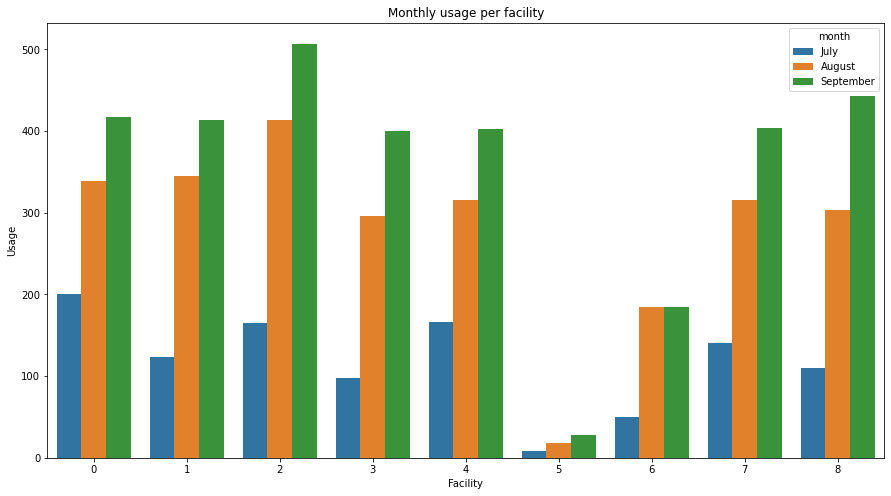

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

ax, fig = plt.subplots(figsize = (15,8))
sns.barplot(data = df_q13, x = 'facid_facility', y = 'slots', hue = 'month')

plt.title('Monthly usage per facility')
# plt.legend(['July','August','September'])
plt.xlabel('Facility')
plt.ylabel('Usage')
plt.show()